## Evaluate Fast-RCNN model directly from python

This notebook demonstrates eveluation of a model trained by the Fast-RCNN implementation of CNTK.

For a full description of the model and the algorithm, please see the following tutorial: https://github.com/Microsoft/CNTK/wiki/Object-Detection-using-Fast-R-CNN 

Below, you will see sample code for:
1. Preparing the input data for the network (including image size adjustments)
2. Evaluation of the input data using the model
3. Processing the evluation result and presenting the selected regions back on the image

Before running this notebook, please make sure that:
<ol>
<li>You have version >= 2.0 of CNTK installed. Installation instructions are available here: https://github.com/Microsoft/CNTK/wiki/Setup-CNTK-on-your-machine

The current assumption is that you have CNTK installed on a windows machine under "c:\local\cntk". You can change the path for the CNTK by changing the "cntk_base_path" variable that is defined below.</li>

<li>You trained the Fast R-CNN model example for the groecry dataset run according to the instructions in the [tutorial above](https://github.com/Microsoft/CNTK/wiki/Object-Detection-using-Fast-R-CNN).<br>
**Important**: Please note that this example works with the Brain Script model that supports version 2.0 of CNTK.
To use the brainscript model, make sure to use following fastrnn.cntk configuration file: https://github.com/Microsoft/CNTK/blob/pkranen/frcnPythonApi/Examples/Image/Detection/FastRCNN/fastrcnn.cntk

The configuration uses the BrainScript version for the AlexNet. Prior to running the A2_RunCntk.py script, you should download the model from: https://www.cntk.ai/Models/AlexNet/AlexNetBS.model and place it under the: "<i>C:\local\cntk\Examples\Image\PretrainedModels</i>" directory.</li>

<li>This notebook uses the CNTK python APIs and should be run from the CNTK python enviornment. The enviornment can be started by running the script: "c:\local\cntk\Scripts\cntkpy34.py".</li>
</ol>

In [3]:
%matplotlib inline
# the above line enable us to draw the images inside the notebooks

# path to the CNTK installation
cntk_base_path = r"C:\local\cntk"

from os.path import join
import sys
sys.path.append(join(cntk_base_path,r"Examples\Image\Detection\FastRCNN"))

## load the model:

In [6]:
from cntk import load_model
frcnn_model = load_model(join(cntk_base_path, r"Examples/Image/Detection/FastRCNN/proc/grocery_2000/cntkFiles/Output/Fast-RCNN.model"))

## Load image and convert it to the network format

The image is loaded using OpenCV, and then resized according to the network input dimensions.

When resizing, we preserve scale and pad the border areas with a constant value (114)

(-0.5, 999.5, 999.5, -0.5)

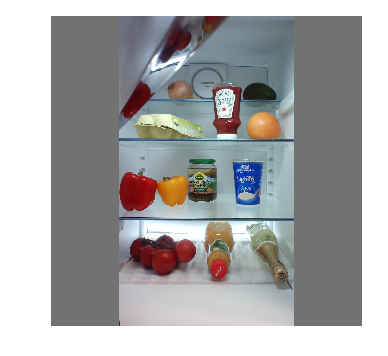

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_height = 1000
image_width = 1000 

def resize_and_pad(img, width, height, pad_value=114):
    # port of the c++ code from CNTK: https://github.com/Microsoft/CNTK/blob/f686879b654285d06d75c69ee266e9d4b7b87bc4/Source/Readers/ImageReader/ImageTransformers.cpp#L316
    img_width = len(img[0])
    img_height = len(img)
    
    scale_w = img_width > img_height
    
    target_w = width
    target_h = height
    
    if scale_w:
        target_h = int(np.round(img_height * float(width) / float(img_width)))
    else:
        target_w = int(np.round(img_width * float(height) / float(img_height)))
        
    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)
    
    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    
    bottom = height - top - target_h
    right = width - left - target_w
    
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])
        
    #tranpose(2,0,1) converts the image to the HWC format which CNTK accepts
    model_arg_rep = np.ascontiguousarray(np.array(resized_with_pad, dtype=np.float32).transpose(2,0,1))
    
    return resized_with_pad, model_arg_rep

def load_image_and_scale(image_path, width, height, pad_value=114):
    img = cv2.imread(image_path)
    return resize_and_pad(img, width, height, pad_value), img

test_image_path = join(cntk_base_path, r"Examples/Image/DataSets/grocery/testImages/WIN_20160803_11_28_42_Pro.jpg")
(test_img, test_img_model_arg), original_img = load_image_and_scale(test_image_path, image_width, image_height)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

## Generate ROIs for testing

Produce ROIs using selective search & a grid, using the same method in the A1_GenerateInputROIs.py script.

Each roi is in the format of [x,y,w,h], where the coordinates real numbers in the range of 0 to 1, and scaled according to the resized and padded image. 
The ROIs arrau is padded with regions of [0,0,0,0] at the end to match the 2000 ROIs input format that the model expects.

In [18]:
# Parameters taken from PARAMETERS.py
# ROI generation
roi_minDimRel = 0.04
roi_maxDimRel = 0.4
roi_minNrPixelsRel = 2    * roi_minDimRel * roi_minDimRel
roi_maxNrPixelsRel = 0.33 * roi_maxDimRel * roi_maxDimRel
roi_maxAspectRatio = 4.0  # maximum aspect Ratio of a ROI vertically and horizontally
roi_maxImgDim = 200       # image size used for ROI generation
ss_scale = 100            # selective search ROIS: parameter controlling cluster size for segmentation
ss_sigma = 1.2            # selective search ROIs: width of gaussian kernal for segmentation
ss_minSize = 20           # selective search ROIs: minimum component size for segmentation
grid_nrScales = 7         # uniform grid ROIs: number of iterations from largest possible ROI to smaller ROIs
grid_aspectRatios = [1.0, 2.0, 0.5]    # uniform grid ROIs: aspect ratio of ROIs
cntk_nrRois = 2000  # 2000 # how many ROIs to zero-pad
cntk_padWidth = 1000
cntk_padHeight = 1000

from cntk_helpers import imArrayWidthHeight, getSelectiveSearchRois, imresizeMaxDim
from cntk_helpers import getGridRois, filterRois, roiTransformPadScaleParams, roiTransformPadScale

def get_rois_for_image(img, use_selective_search=True, use_grid_rois=True):
    
    roi_minDim = roi_minDimRel * roi_maxImgDim
    roi_maxDim = roi_maxDimRel * roi_maxImgDim
    roi_minNrPixels = roi_minNrPixelsRel * roi_maxImgDim*roi_maxImgDim
    roi_maxNrPixels = roi_maxNrPixelsRel * roi_maxImgDim*roi_maxImgDim


    imgOrig = img.copy()

    # get rois
    if use_selective_search:
        print ("Calling selective search..")
        rects, scaled_img, scale = getSelectiveSearchRois(imgOrig, ss_scale, ss_sigma, ss_minSize, roi_maxImgDim) #interpolation=cv2.INTER_AREA
        print ("Number of rois detected using selective search: " + str(len(rects)))
    else:
        rects = []
        scaled_img, scale = imresizeMaxDim(imgOrig, roi_maxImgDim, boUpscale=True, interpolation=cv2.INTER_AREA)
        
    imgWidth, imgHeight = imArrayWidthHeight(scaled_img)

    # add grid rois
    if use_grid_rois:
        rectsGrid = getGridRois(imgWidth, imgHeight, grid_nrScales, grid_aspectRatios)
        print ("Number of rois on grid added: " + str(len(rectsGrid)))
        rects += rectsGrid

    # run filter
    print ("Number of rectangles before filtering  = " + str(len(rects)))
    rois = filterRois(rects, imgWidth, imgHeight, roi_minNrPixels, roi_maxNrPixels, roi_minDim, roi_maxDim, roi_maxAspectRatio)
    if len(rois) == 0: #make sure at least one roi returned per image
        rois = [[5, 5, imgWidth-5, imgHeight-5]]
    print ("Number of rectangles after filtering  = " + str(len(rois)))

    # scale up to original size and save to disk
    # note: each rectangle is in original image format with [x,y,x2,y2]
    original_rois = np.int32(np.array(rois) / scale)
    
    img_width = len(img[0])
    img_height = len(img)

    # all rois need to be scaled + padded to cntk input image size
    targetw, targeth, w_offset, h_offset, scale = roiTransformPadScaleParams(img_width, img_height,
                                                               cntk_padWidth, cntk_padHeight)
    
    rois = []
    for original_roi in original_rois:
        x, y, x2, y2 = roiTransformPadScale(original_roi, w_offset, h_offset, scale)

        xrel = float(x) / (1.0 * targetw)
        yrel = float(y) / (1.0 * targeth)
        wrel = float(x2 - x) / (1.0 * targetw)
        hrel = float(y2 - y) / (1.0 * targeth)
        
        rois.append([xrel, yrel, wrel, hrel])
    
    # pad rois if needed:
    if len(rois) < cntk_nrRois:
        rois += [[0, 0, 0, 0]] * (cntk_nrRois - len(rois))
    elif len(rois) > cntk_nrRois:
        rois = rois[:cntk_nrRois]
    return np.array(rois), original_rois
    
test_rois, original_rois = get_rois_for_image(original_img)
roi_padding_index = len(original_rois)
print("number of rois:", len(test_rois))

Calling selective search..
Number of rois detected using selective search: 590
Number of rois on grid added: 110580
Number of rectangles before filtering  = 111170
Number of rectangles after filtering  = 1345
number of rois: 2000


## Evaluate the sample
Prepare the data to be in CNTK's expected arguments format and run it through the model

Process the result by trimming the padded rois part, and calculate the predicted labels and probabilites

In [20]:
from cntk_helpers import softmax2D

# a dummy variable for labels the will be given as an input to the network but will be ignored
dummy_labels = np.zeros((2000,17))

# prepare the arguments
arguments = {
    frcnn_model.arguments[1]: [test_img_model_arg],
    frcnn_model.arguments[0]: [test_rois],
    frcnn_model.arguments[2] : [dummy_labels]
}

# run it through the model
output = frcnn_model.eval(arguments)

# take just the relevant part and cast to float64 to prevent overflow when doing softmax
rois_values = output[frcnn_model.outputs[2]][0][0][:roi_padding_index].astype(np.float64)

# get the prediction for each roi by taking the index with the maximal value in each row 
rois_labels_predictions = np.argmax(rois_values, axis=1)

# calculate the probabilities using softmax
rois_probs = softmax2D(rois_values) 

# print the number of ROIs that were detected as non-background
print("Number of detections: %d"%np.sum(rois_labels_predictions > 0))

Number of detections: 75


C:\local\cntk\Examples\Image\Detection\FastRCNN\cntk_helpers.py:808: RuntimeWarning: overflow encountered in exp
  e = np.exp(w)
C:\local\cntk\Examples\Image\Detection\FastRCNN\cntk_helpers.py:809: RuntimeWarning: invalid value encountered in true_divide
  dist = e / np.sum(e, axis=1)[:, np.newaxis]


### Merge overlapping regions using Non Maxima Supression
The code below merged overlapping regions that were detected using Non-Maxima-Supression algorithm that is implemented in the cntk_helpers module

In [16]:
from cntk_helpers import applyNonMaximaSuppression
nms_threshold = 0.1
non_padded_rois = test_rois[:roi_padding_index]
max_probs = np.amax(rois_probs, axis=1).tolist()
rois_prediction_indices = applyNonMaximaSuppression(nms_threshold, rois_labels_predictions, max_probs, non_padded_rois)
print("Indices of seletected regions:",rois_prediction_indices)

Indices of seletected regions: [250, 546, 526, 529, 1086, 1187, 1118, 688, 7, 352]


## Visualize the results

As a final step, we use the OpenCV **rectangle** library in order to draw the seleted regions on the original image

(-0.5, 1079.5, 1919.5, -0.5)

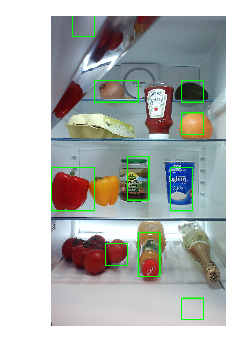

In [17]:
rois_with_prediction = test_rois[rois_prediction_indices]
rois_prediction_labels = rois_labels_predictions[rois_prediction_indices]
rois_predicion_scores = rois_values[rois_prediction_indices]
original_rois_predictions = original_rois[rois_prediction_indices]

original_img_cpy = original_img.copy()
for roi in original_rois_predictions:
    (x1,y1,x2,y2) = roi
    cv2.rectangle(original_img_cpy, (x1, y1), (x2, y2), (0, 255, 0), 5)

plt.imshow(cv2.cvtColor(original_img_cpy, cv2.COLOR_BGR2RGB))
plt.axis("off")